In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pycqed import *

# Qubit-Resonator Example

Resonators are used extensively for Quantum Non-Demolition (QND) measurements of circuit observables. Here we show how to couple a resonator capacitively to an RF-SQUID qubit, and determine the resonator modulation and shifts dependent on the qubit state. Currently the code uses the RWA approximation and assumes weak coupling. See [A. Blais _et al_][1] for the background to qubit-resonator coupling in the dispersive limit, and see [D. Sank _et al_][2] for the methodology adopted for calculating the interaction Hamiltonian and the response of the resonator.

[1]: https://journals.aps.org/pra/abstract/10.1103/PhysRevA.69.062320
[2]: https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.117.190503

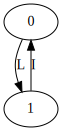

In [2]:
graph = CircuitGraph()
graph.addBranch(0, 1, "C")
graph.addBranch(0, 1, "L")
graph.addBranch(0, 1, "I")
graph.drawGraphViz("SCGraph")

To couple a resonator capacitively to the system we only need to indicate this to the graph structure using:

In [3]:
graph.coupleResonatorCapacitively(1, "Cc")

Where we call the coupling capacitor between resonator and qubit as $C_c$ and indicate that the resonator is coupled to node 1 via this capacitor.

In [4]:
circuit = SymbolicSystem(graph)

The introduction of the resonator causes a loading effect on the rest of the circuit. This is accounted for in the capacitance matrix:

In [5]:
circuit.getCapacitanceMatrix()

Matrix([[C_{1r}*C_{c}/(C_{1r} + C_{c}) + C_{}]])

Where we see the coupling capacitor and the automatically created capacitor associated with the resonator.

The addition of the resonator introduces a new node, that we'll call 2, to the circuit. Then, the terms involving $Q_1$ and $Q_2$ form the interaction part of the Hamiltonian. Since $Q_1$ and $Q_2$ commute, we will have

$$\hat{H}_\mathrm{int} = \frac{C_c \hat{Q}_1 \hat{Q}_2}{C_{1r} C_c + C_{1r} C + C_c C} = g_0 \hat{Q}_1 \hat{Q}_2$$

where $g_0$ is the coupling constant of the system. Under the hood, an oscillator basis is used for the charge and flux degrees of freedom of the resonator. The resulting frequency and impedance is then lumped into the constant $g_0$, which results in an expression like Eq. (17) of [A. Blais _et al_][1]:

[1]: https://journals.aps.org/pra/abstract/10.1103/PhysRevA.69.062320

In [6]:
circuit.resonator_symbols_expr[1]['gC']

0.707106781186547*C_{c}/((L_{1r}*(C_{c} + C_{})/(C_{1r}*C_{c} + C_{1r}*C_{} + C_{c}*C_{}))**(1/4)*(C_{1r}*C_{c} + C_{1r}*C_{} + C_{c}*C_{}))

Now we'll instantiate the numerical system:

In [7]:
hamil = NumericalSystem(circuit)
hamil.configureOperator(1, 101, "oscillator")

Using existing PyCQED tmp output root directory 'C:\Users\LFRYBO~1\AppData\Local\Temp\.pycqed\'.


We see the resonator parameters have been added to the main parameter list, including all the parameters related to the resonator.

In [8]:
hamil.all_params_sym

{'C': C_{},
 'L': L_{},
 'I': I_{},
 'Cc': C_{c},
 'f1r': f_{1r},
 'Z1r': Z_{1r},
 'C1r': C_{1r},
 'L1r': L_{1r},
 'g1r': g_{1r},
 'f1rl': f_{1rl},
 'Z1rl': Z_{1rl},
 'phi10-2e': \Phi_{10-2e}}

Before we do sweeps of the resonator response, we need to configure the diagonaliser to return the eigenvectors of the Hamiltonian at each point, as the calculation depends on these. We also ask for more than the default 5 eigenvalues to be returned to ensure sufficient coupling terms are calculated when building the RWA strips:

In [9]:
hamil.setDiagConfig(get_vectors=True, eigvalues=20)

Since the resonator response depends on the Hamiltonian, we configure the sweeper to use the results obtained from it. We must specify which node the resonator is connected to.

In [10]:
# Configure the parameter sweep
spec = [
    hamil.sweepSpec('phi10-2e', 0.49, 0.51, 401)
]

# Configure the items to be evaluated
evals = [
    hamil.evalSpec('getHamiltonian', True, None),
    hamil.evalSpec('getResonatorResponse', False, "getHamiltonian", cpl_node=1),
]

Now we set the parameter values of the qubit and the resonator. We will choose a small coupling capacitor of 5 fF. We also set the design frequency and impedance of the resonator. The loaded resonator frequency and impedance, the capacitance and inductance required for the design resonator, and the coupling terms are automatically calculated.

In [11]:
# Fabrication parameters
Ca = 60.0 # fF/um^2
Jc = 3.0  # uA/um^2
Aj = 0.2*1.2#0.4**2 # um^2
L = 550 # pH

hamil.setParameterValues(
    'L', L,
    'C', Ca*Aj,
    'I', Jc*Aj,
    'phi10-2e', 0.5,
    'f1r', 7.9,
    'Z1r', 50.0,
    'Cc', 0.5
)

Now we do the sweep:

In [12]:
sweep = hamil.paramSweep(spec, eval_spec=evals, timesweep=True)

Parameter Sweep Duration:
  Initialization:	0.057 s
  Loop duration:	15.610 s
  Avg iteration:	0.039 s


The `getResonatorResponse` function returns the full set of dressed qubit eigenvalues for each number of resonator photons specified. The default is 100, and this can be set as keyword arguments passed to the `evalSpec` entry of for `getResonatorResponse`. Let's first look at the spectrum of the bare capacitively loaded RF-SQUID:

In [13]:
x,EV,v = hamil.getSweep(sweep, 'phi10-2e', {}, evaluable='getHamiltonian')
E = EV[:, 0]
V = EV[:, 1]

Text(0, 0.5, '$E_{g,i}$ (GHz)')

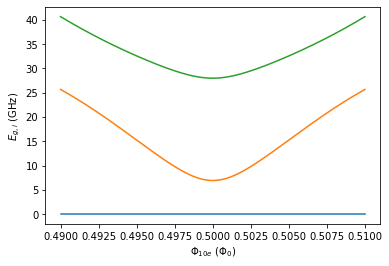

In [14]:
for i in range(3):
    y = E[i] - E[0]
    plt.plot(x,y,ls="-")
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("$E_{g,i}$ (GHz)")

### Resonator Parameters

As we haven't swept a circuit component, the parameter values here have not changed:

In [15]:
# Design resonator frequency
hamil.getParameterValue('f1r')

7.9

In [16]:
# Loaded bare resonator frequency
hamil.getParameterValue('f1rl')

7.89526707231005

In [17]:
# Design resonator impedance
hamil.getParameterValue('Z1r')

50.0

In [18]:
# Loaded bare resonator impedance
hamil.getParameterValue('Z1rl')

49.97004476145601

In [19]:
# Coupling term
hamil.getParameterValue('g1r')

0.04132308545828593

In [20]:
# Resonator capacitance
hamil.getParameterValue('C1r')

402.9239065617603

In [21]:
# Resonator inductance
hamil.getParameterValue('L1r')

1007.3097664044009

### Circuit Lamb Shift

Now let's look at the dressed (Lamb shifted) spectrum of the capacitively loaded RF-SQUID, which can be extracted using the `getCircuitLambShift` utility function:

In [22]:
x, Erwa, v = hamil.getSweep(sweep, 'phi10-2e', {}, evaluable='getResonatorResponse')
Edressed = util.getCircuitLambShift(Erwa)

Text(0, 0.5, '$E_{g,i}$ (GHz)')

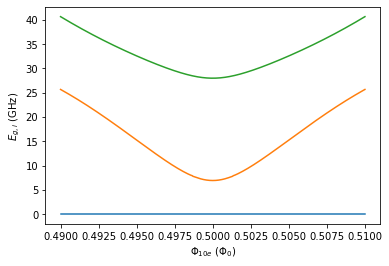

In [23]:
for i in range(3):
    y = Edressed[i]
    plt.plot(x, y, ls="-")
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("$E_{g,i}$ (GHz)")

Because the coupling here is small compared to the total Hamiltonian, we cannot easily see the avoided crossing region where the qubit energy crosses the resonator resonant frequency. We can more easily see this by focusing in that region:

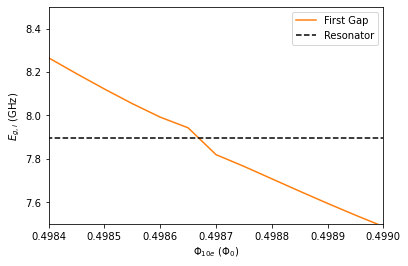

In [24]:
# Get the loaded bare resonator frequency
fr = hamil.getParameterValue('f1rl')

#
plt.plot(x, Edressed[1], "C1-", label="First Gap")
plt.plot([x[0], x[-1]], [fr, fr], "k--", label="Resonator")
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("$E_{g,i}$ (GHz)")
plt.xlim(0.4984, 0.499)
plt.ylim(7.5, 8.5)
plt.legend()

We can observe the Lamb shift directly by taking the difference of the dressed levels with those of the (loaded) isolated qubit:

Text(0, 0.5, '$\\Delta E_{g,i}$ (MHz)')

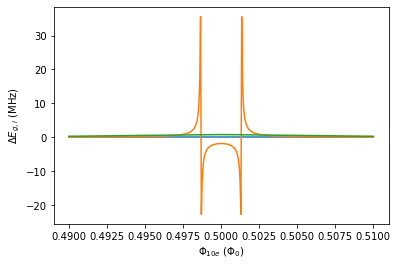

In [25]:
for i in range(3):
    y = (Edressed[i] - (E[i] - E[0]))*1e3
    plt.plot(x,y,ls="-")
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("$\Delta E_{g,i}$ (MHz)")

### Resonator Shift

Now let's look at the resonator modulation when the qubit is in the ground as the external flux is changed. We can use the `getResonatorShift` utility function to extract this:

In [26]:
Eres = util.getResonatorShift(Erwa)

Text(0, 0.5, '$\\omega_{r}$ (GHz)')

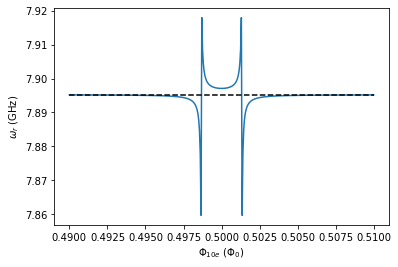

In [27]:
plt.plot(x, Eres[0,0])
plt.plot([x[0], x[-1]], [fr, fr], "k--")
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("$\omega_{r}$ (GHz)")

As expected we see the resonator shift change sign in the region where the qubit energy is less than the resonator frequency. The shift near half flux is on the order of a MHz.

Now we can look at the resonator frequency when the qubit is in different excited states:

Text(0, 0.5, '$\\omega_{r}$ (GHz)')

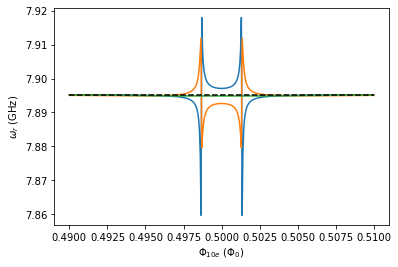

In [28]:
plt.plot(x, Eres[0,0], label="Gnd State")
plt.plot(x, Eres[1,0], label="Ex State 1")
plt.plot(x, Eres[2,0], label="Ex State 2")
plt.plot([x[0], x[-1]], [fr, fr], "k--")
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("$\omega_{r}$ (GHz)")

We can plot the change in frequency when the qubit goes from the ground state to the first and second excited states by taking the difference with the ground state resonator modulation curve:

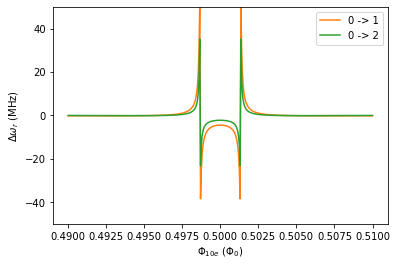

In [29]:
plt.plot(x, (Eres[1,0]-Eres[0,0])*1e3, "C1-", label="0 -> 1")
plt.plot(x, (Eres[2,0]-Eres[0,0])*1e3, "C2-", label="0 -> 2")
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("$\Delta\omega_{r}$ (MHz)")
plt.ylim(-50, 50)
plt.legend()

We see that for these parameters, the shift of the resonator when the qubit is excited is on the order of 10 MHz. We also see that the resonator is affected very little for a small flux away from half flux. This is due to the qubit energy becoming so large in those regions that the resonator and qubit are effectively decoupled.

### AC Stark Shift

Now we can look at the AC Stark shift of the qubit energy levels as the average number of photons in the resonator is increased. We can use the utility function `getACStarkShift` to extract these:

In [30]:
n, Eacstark = util.getACStarkShift(Erwa)

Now we can plot the AC Stark shifted energy gaps as a function of the photon number at half flux:

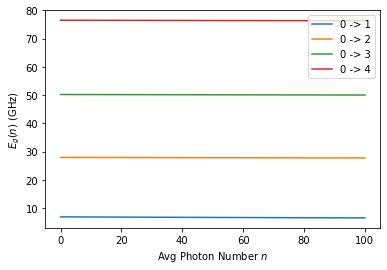

In [31]:
for i in range(4):
    plt.plot(n, Eacstark[i, :, 200], label="0 -> %i" % (i+1))
plt.xlabel("Avg Photon Number $n$")
plt.ylabel("$E_g(n)$ (GHz)")
plt.legend()

To get the AC Stark shift itself, we can take the difference with the Lamb shifted levels:

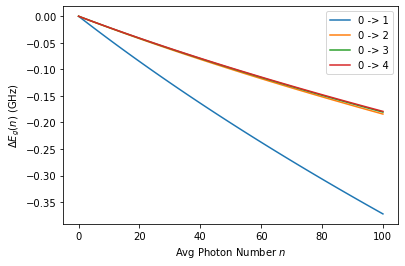

In [32]:
for i in range(4):
    plt.plot(n, Eacstark[i, :, 200]-Edressed[i+1, 200], label="0 -> %i" % (i+1))
plt.xlabel("Avg Photon Number $n$")
plt.ylabel("$\\Delta E_g(n)$ (GHz)")
plt.legend()

We see the AC Stark shift is negative, as is expected in these types of qubits, and is also quite large. The effect of the AC Stark shift of the qubit can be observed on the resonator also, since the resonator shift depends on the qubit energy. We can plot this shift using the result from `getResonatorShift`:

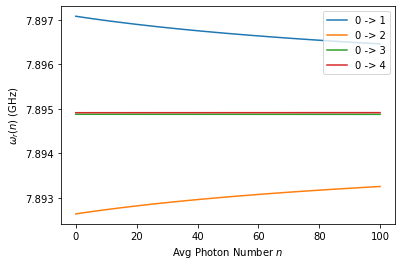

In [33]:
for i in range(4):
    plt.plot(n, Eres[i, :, 200], label="0 -> %i" % (i+1))
plt.xlabel("Avg Photon Number $n$")
plt.ylabel("$\\omega_r(n)$ (GHz)")
plt.legend()

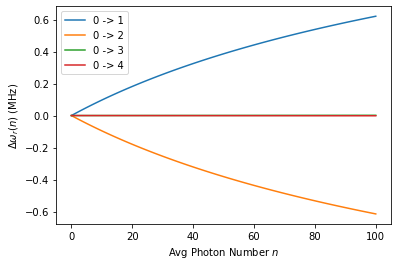

In [34]:
for i in range(4):
    plt.plot(n, (Eres[i, 0, 200]-Eres[i, :, 200])*1e3, label="0 -> %i" % (i+1))
plt.xlabel("Avg Photon Number $n$")
plt.ylabel("$\\Delta\\omega_r(n)$ (MHz)")
plt.legend()

### Full Circuit Spectrum

Now we look at the full circuit spectrum to illustrate the importance of treating a coupled resonator as a subsystem for qubit applications. To do this we can create a new circuit that includes the resonator explicitly:

In [35]:
graph = CircuitGraph()
graph.addBranch(0, 1, "C")
graph.addBranch(0, 1, "L")
graph.addBranch(0, 1, "I")
graph.addBranch(0, 2, "C1r")
graph.addBranch(0, 2, "L1r")
graph.addBranch(1, 2, "Cc")

In [36]:
circuit = SymbolicSystem(graph)
circuit.getInverseCapacitanceMatrix()

Matrix([
[(C_{1r} + C_{c})/(C_{1r}*C_{c} + C_{1r}*C_{} + C_{c}*C_{}),          C_{c}/(C_{1r}*C_{c} + C_{1r}*C_{} + C_{c}*C_{})],
[           C_{c}/(C_{1r}*C_{c} + C_{1r}*C_{} + C_{c}*C_{}), (C_{c} + C_{})/(C_{1r}*C_{c} + C_{1r}*C_{} + C_{c}*C_{})]])

In [37]:
hamilf = NumericalSystem(circuit)
hamilf.configureOperator(1, 41, "oscillator")
hamilf.configureOperator(2, 41, "oscillator")
hamilf.getParameterNames()

Using existing PyCQED tmp output root directory 'C:\Users\LFRYBO~1\AppData\Local\Temp\.pycqed\'.


['C', 'L', 'I', 'C1r', 'L1r', 'Cc', 'phi10-2e']

Now we set the parameters according to our previous simulations:

In [38]:
# Fabrication parameters
Ca = 60.0 # fF/um^2
Jc = 3.0  # uA/um^2
Aj = 0.2*1.2#0.4**2 # um^2
L = 550 # pH

hamilf.setParameterValues(
    'L', L,
    'C', Ca*Aj,
    'I', Jc*Aj,
    'phi10-2e', 0.5,
    'C1r', hamil.getParameterValue("C1r"),
    'L1r', hamil.getParameterValue("L1r"),
    'Cc', 0.5
)

In [39]:
spec = [
    hamilf.sweepSpec('phi10-2e', 0.4984, 0.4988, 101)
]
hamilf.setDiagConfig(eigvalues=20)
sweep = hamilf.paramSweep(spec, timesweep=True)

Parameter Sweep Duration:
  Initialization:	0.162 s
  Loop duration:	102.373 s
  Avg iteration:	1.014 s


We will compare the full spectrum to the reconstructed dressed states of the loaded system:

Text(0, 0.5, '$E_{g,i}$ (GHz)')

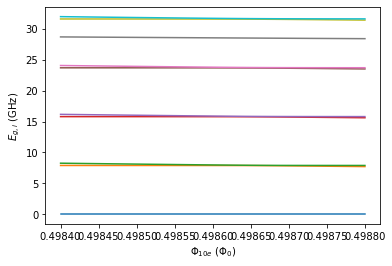

In [40]:
x, Efull, v = hamilf.getSweep(sweep, 'phi10-2e', {})
for i in range(10):
    plt.plot(x, Efull[i]-Efull[0])
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("$E_{g,i}$ (GHz)")

We see the level structure is actually very confusing when solved this way. It is very difficult to tell from this spectrum which level is associated with which qubit state and photon number, particularly at higher energy states. Thus it is very difficult to extract quantities useful to qubit characterisation such as the Lamb and AC Stark shift of the qubit and the resonator.

Here however we can recognize the avoided crossing between the single photon resonator level and the first qubit excited state. Putting them side-by-side:

In [41]:
# Configure the items to be evaluated on the previous system
evals = [
    hamil.evalSpec('getHamiltonian', True, None),
    hamil.evalSpec('getResonatorResponse', False, "getHamiltonian", cpl_node=1),
]

sweep = hamil.paramSweep(spec, eval_spec=evals, timesweep=True)
x, Erwa, v = hamil.getSweep(sweep, 'phi10-2e', {}, evaluable='getResonatorResponse')
Edressed = util.getCircuitLambShift(Erwa)

Parameter Sweep Duration:
  Initialization:	0.051 s
  Loop duration:	4.529 s
  Avg iteration:	0.045 s


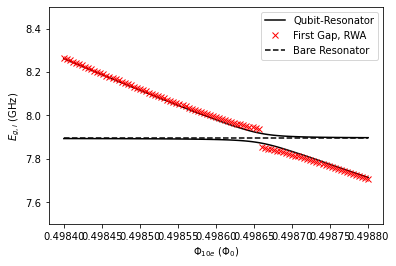

In [42]:
plt.plot(x,Efull[1]-Efull[0],"k-")
plt.plot(x,Efull[2]-Efull[0],"k-",label="Qubit-Resonator")
plt.plot(x,Edressed[1],"rx",label="First Gap, RWA")
plt.plot([x[0], x[-1]], [fr, fr],"k--",label="Bare Resonator")
plt.xlabel("$\\Phi_{10e}$ ($\\Phi_0$)")
plt.ylabel("$E_{g,i}$ (GHz)")
#plt.xlim(0.4976,0.498)
plt.ylim(7.5,8.5)
plt.legend()